In [53]:
import pandas as pd
import datetime as dt
from IPython.display import display
from sklearn.impute import SimpleImputer

class DataPreprocessor:
    def __init__(self, filename):
        self.filename = filename
        self.df = pd.read_csv(self.filename)
    
    def drop_duplicates(self):
        remove_duplicates = input("Do you want to remove duplicates? Input T or F ") == "T"
        if remove_duplicates:
            self.df.drop_duplicates(inplace=True)
    
    def impute_missing(self, method='mean'):
        impute_values = input("Do you want to impute values? Input T or F ") == "T"
        if impute_values:
            impute_strategy = input("How do you want to impute your values? e.g. \"median\", \"0\" " )
            imputer = SimpleImputer()
            if impute_strategy.isdigit():
                imputer = SimpleImputer(strategy='constant', fill_value=int(impute_strategy))
            else:
                imputer = SimpleImputer(strategy = impute_strategy)
            self.df = pd.DataFrame(imputer.fit_transform(self.df), columns=self.df.columns)
    def display_table(self):
        display(self.df)
        to_csv = input("This is your new data file -- do you want to download it? Input T or F ") == "T"
        if to_csv:
            # Get the current timestamp
            timestamp = dt.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

            # Define the output filename
            # Split the filename into basename and extension
            basename, extension = os.path.splitext(self.filename)
            download_filename = f'{basename}_{timestamp}{extension}'

            # Download the dataframe to the output file
            self.df.to_csv(download_filename, index=False)
            
    def return_data(self):
        return self.df.iloc[:, :-1].values
        
    def return_labels(self):
        return self.df.iloc[:, -1].values


In [83]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import f1_score, recall_score, precision_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings

class Clustering:
    def __init__(self, data):
        self.data = data
        self.pc_to_plot = 2
        
        #used to calculate different scores, if needed
        self.labels = None
    
    def f1_score(self, labels_true):
        return f1_score(labels_true, self.labels)
    
    def recall_score(self, labels_true):
        return recall_score(labels_true, self.labels)
    
    def precision_score(self, labels_true):
        return precision_score(labels_true, self.labels)
    
    def silhouette_score(self, data):
        return silhouette_score(data, self.labels)
    
    def cluster(self):
        raise NotImplementedError()
        

class KMeansClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    def elbow_method(self):
        # Calculate the within-cluster sum of squares (WCSS) for each k value
        wcss = []
        
        # Define range of k values to test
        k_values = range(1, 10)
        
        for k in k_values:
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(self.data)
            wcss.append(kmeans.inertia_)

        # Plot the elbow curve
        plt.plot(k_values, wcss, 'bx-')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('WCSS')
        plt.title('Elbow Method')

        # Determine the optimal number of clusters
        diffs = np.diff(wcss)
        diff_ratios = diffs[1:] / diffs[:-1]
        optimal_k = k_values[np.argmin(diff_ratios) + 1]

        # Display the optimal number of clusters
        plt.axvline(x=optimal_k, linestyle='--', color='r', label=f'Optimal k={optimal_k}')
        plt.legend()
        plt.show()

        print(f"Optimal number of clusters: {optimal_k}")
        
        return optimal_k
    
    def cluster(self, n_clusters=None):
        warnings.filterwarnings("ignore")
        if n_clusters is None:
            n_clusters = self.elbow_method()
        kmeans = KMeans(n_clusters=n_clusters)
        self.labels = kmeans.fit_predict(self.data)
        
        #plot the clusters
        self.plot_clusters(kmeans)
    
    def plot_clusters(self, kmeans):
        # Fit PCA to the data
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(self.data)

        # Plot the clustered data on the two principal components
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')

        # Plot the centroids on the two principal components
        centroids_pca = pca.transform(kmeans.cluster_centers_)
        plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='x', s=100, linewidths=3, color='r')

        # Set plot title and axis labels
        plt.title('K-means Clustering on PCA')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        
        # Remove values on the x and y axes
        plt.tick_params(labelbottom=False, labelleft=False)

        # Show the plot
        plt.show()

class DBSCANClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    def cluster(self, eps=None, min_samples=None):
        warnings.filterwarnings("ignore")
        if eps is None:
#             eps = np.sqrt(self.data.shape[1])
            eps=5000
        if min_samples is None:
            min_samples = 2 * self.data.shape[1]
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        self.labels = dbscan.fit_predict(self.data)
        
        #plot the clusters
        self.plot_clusters(dbscan)
    
    def plot_clusters(self, dbscan):
        # Fit PCA to the data
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(self.data)
        
        # Get the cluster labels and the number of clusters
        labels = dbscan.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Plot the data points colored by cluster
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='viridis')
        plt.title(f'DBSCAN Clustering on PCA (Number of Clusters: {n_clusters})')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        
        # Remove values on the x and y axes
        plt.tick_params(labelbottom=False, labelleft=False)
        
        #Show the plot
        plt.show()

In [84]:
class App:
    def __init__(self, filename):
        #filename = input("Please enter the name of your csv file ")
        self.preprocessor = DataPreprocessor(filename)
        self.clustering = None
        
    def start(self):
        
        # Ask the user for preprocessing options
        self.preprocessor.drop_duplicates()
        self.preprocessor.impute_missing()

        # Show the user how the new table looks, and ask the user if he/she wants to download it
        self.preprocessor.display_table()

        data = self.preprocessor.return_data()

        # Ask the user for clustering options
        algorithm = input('Which clustering algorithm do you wish to use? (kmeans/dbscan) ')

        if algorithm == "kmeans":
            self.clustering = KMeansClustering(data)
        if algorithm == "dbscan":
            self.clustering = DBSCANClustering(data)

        # Perform clustering
        self.clustering.cluster()
        
        # Measure performance
        silhouette_score = self.clustering.silhouette_score(data)

        # Print the score
        print("Silhouette score:", silhouette_score)


Do you want to remove duplicates? Input T or F T
Do you want to impute values? Input T or F T
How do you want to impute your values? e.g. "median", "0" mean


,Unnamed: 0,bright_sum,bright_size,bright_density,dark_sum,dark_size,dark_density
0,0.0,2200.0,21.0,104.761905,0.0,0.0,137.861505
1,1.0,5411.0,48.0,112.729167,0.0,0.0,137.861505
2,2.0,4041.0,37.0,109.216216,0.0,0.0,137.861505
3,3.0,16782.0,149.0,112.630872,0.0,0.0,137.861505
4,4.0,31296.0,267.0,117.213483,0.0,0.0,137.861505
...,...,...,...,...,...,...,...
1934,1934.0,0.0,0.0,116.969190,46759.0,368.0,127.062500
1935,1935.0,0.0,0.0,116.969190,26529.0,203.0,130.684729
1936,1936.0,2692.0,25.0,107.680000,120569.0,957.0,125.986416
1937,1937.0,4334.0,41.0,105.707317,84513.0,643.0,131.435459


This is your new data file -- do you want to download it? Input T or F F
Which clustering algorithm do you wish to use? (kmeans/dbscan) dbscan


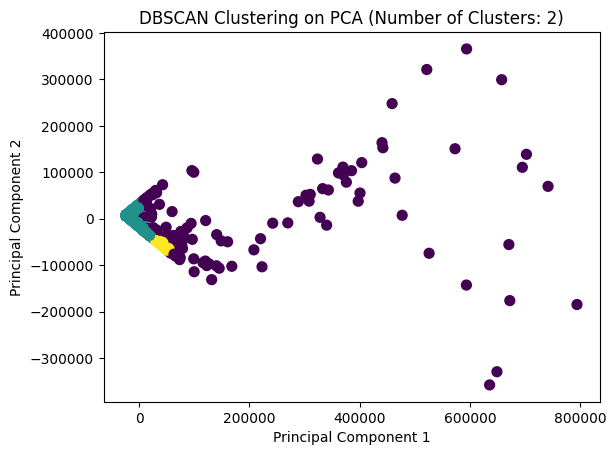

Silhouette score: 0.6826327725245062


In [85]:
app = App("mura_data.csv")
app.start()